# Weight Initialization

Reference
- [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
- [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/pdf/1502.01852v1.pdf)
- [Understanding Neural Network Weight Initialization](https://intoli.com/blog/neural-network-initialization/)

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
class Net(nn.Module):
    def __init__(self, activation_f):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(16, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)
        
        self.f = activation_f
        self.activation_value = {}

    def forward(self, x):
        x = self.f(self.fc1(x))
        self.activation_value[1] = x
        x = self.f(self.fc2(x))
        self.activation_value[2] = x
        x = self.f(self.fc3(x))
        self.activation_value[3] = x
        x = self.f(self.fc4(x))
        self.activation_value[4] = x
        x = self.f(self.fc5(x))
        self.activation_value[5] = x
        
        return self.fc6(x)

    def init_normal(self, std):
        for p in self.modules():
            if isinstance(p, nn.Linear):
                nn.init.normal_(p.weight, mean=0.0, std=std)
                nn.init.constant_(p.bias, 0.0)
                
    def init_kaiming_normal(self):
        for p in self.modules():
            if isinstance(p, nn.Linear):
                nn.init.kaiming_normal_(p.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(p.bias, 0.0)
                
    def init_xavier_normal(self):
        for p in self.modules():
            if isinstance(p, nn.Linear):
                nn.init.xavier_normal_(p.weight, gain=1.0)
                nn.init.constant_(p.bias, 0.0)
                

# def init_kaiming_normal(fc):
#     if isinstance(fc, nn.Linear):
#         nn.init.kaiming_normal_(fc.weight, mode='fan_out', nonlinearity='relu')
#         nn.init.constant_(fc.bias, 0.0)

# model.apply(init_kaiming_normal)

In [3]:
def get_activation_df(activation_f, sigma, x_std=0.5):
    model = Net(activation_f)
    model.init_normal(sigma)
    
    x = torch.normal(0, x_std, [16])
    y = model(x)
    
    activation_per_layer = []

    for i in range(1,6):
        activation_per_layer.append(np.c_[np.repeat(sigma, 64), np.repeat(i, 64), model.activation_value[i].detach().numpy()])

    df = pd.DataFrame(np.concatenate(activation_per_layer, axis=0), columns=['Standard Deviation', 'Hidden Layer', 'Output'])
    
    return df

In [4]:
def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def get_activation_plot(df, activation, initialization, sigmas):
    # Plot previously saved activations from the 5 hidden layers
    # using different initialization schemes.
    height = len(sigmas)*3
    
    fig = plt.figure(figsize=(12, height))
    axes = grid_axes_it(len(sigmas), 1, fig=fig)
    for sig in sigmas:
        ax = next(axes)
        if initialization == 'normal':
            ddf = df[df['Standard Deviation'] == sig]
        else:
            ddf = df
        
        sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

        ax.set_xlabel('')
        ax.set_ylabel('')
        
        if initialization == 'normal':
            title_str = 'Initialization: [init] | Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$'
            title_str = title_str.replace("[init]", initialization)
            ax.set_title(title_str % sig, fontsize=13)
        else: 
            title_str = 'Initialization: [init]'.replace("[init]", initialization)
            ax.set_title(title_str, fontsize=13)

        if initialization == 'normal':
            if sig == sigmas[1]:
                ax.set_ylabel("[act] | Neuron Outputs".replace("[act]", activation))
            if sig != sigmas[-1]:
                ax.set_xticklabels(())
            else:
                ax.set_xlabel("Hidden Layer")
        else:
            ax.set_ylabel("[act] | Neuron Outputs".replace("[act]", activation))
            ax.set_xticklabels(())
            ax.set_xlabel("Hidden Layer")

    plt.tight_layout()
    plt.show()

## Activation: ReLU | Normal initialization | Post activation distribution
Below are violin plot of post activation distribution: `F.relu(self.fc(x))`
- Activation is imbalanced between front and back layers if not properly initializated
- When $\sigma=0.1$, activation at layer 1 is proper but activation at layer 5 is too small
- When $\sigma=0.3$, activation at layer 1 is proper but activation at layer 5 is too big
- Likely result in vanishing / exploding gradients

/tmp/ipykernel_12674/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
/tmp/ipykernel_12674/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
/tmp/ipykernel_12674/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


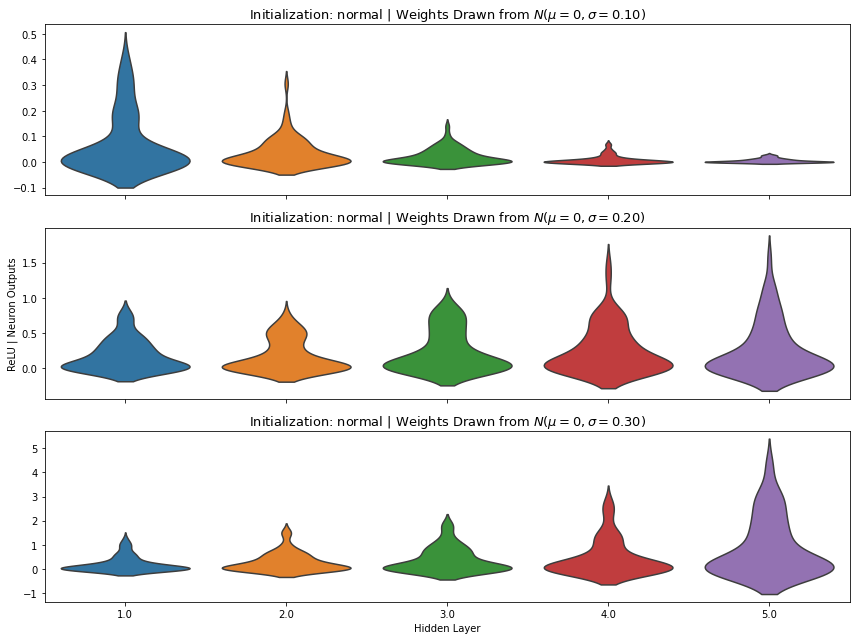

In [5]:
sigma_list = [0.10, 0.2, 0.3]
df_list = []

for sigma in sigma_list:    
    df_list.append(get_activation_df(F.relu, sigma))
    
dff = pd.concat(df_list)
get_activation_plot(dff, 'ReLU', 'normal', sigma_list)

## Activation: ReLU | Kaiming initialization | Post activation distribution
- No hyperparameter required
- No activation imbalance

In [6]:
model = Net(F.relu)
model.init_kaiming_normal()

x = torch.normal(0, 1, [16])
y = model(x)

activation_per_layer = []

for i in range(1,6):
    activation_per_layer.append(np.c_[np.repeat(sigma, 64), np.repeat(i, 64), model.activation_value[i].detach().numpy()])

df = pd.DataFrame(np.concatenate(activation_per_layer, axis=0), columns=['Standard Deviation', 'Hidden Layer', 'Output'])

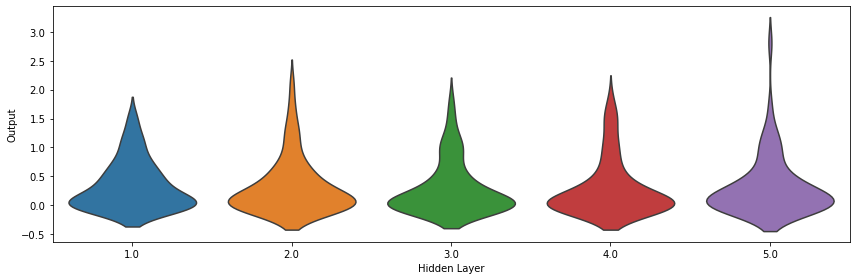

In [7]:
height = 5

fig = plt.figure(figsize=(12, 4))

sns.violinplot(x='Hidden Layer', y='Output', data=df, scale='count', inner=None)

plt.tight_layout()
plt.show()

## Activation: ReLU | Normal & Kaiming initialization | Gradient distribution
Below are violinplot of gradient computed from first batch of data
- Just from the gradient distribution, we cannot tell if Kaiming initialization better
- Need to run multiple epochs to tell the difference

In [10]:
def plot_gradient_dist(model):
    opt = SGD(model.parameters(), lr=1e-3)
    # compute gradient
    opt.zero_grad() 
    x = torch.normal(0, 0.5, [16])
    y = model(x)
    loss = F.mse_loss(y, torch.tensor([0.0]))
    print(loss)
    loss.backward()

    # create df for activation data
    gradient_per_layer = []
    layers = [model.fc1, model.fc2, model.fc3, model.fc4, model.fc5]

    for i, layer in enumerate(layers):
        gradient_per_layer.append(np.c_[np.repeat(i+1, 64), layer.weight.grad.detach().numpy().mean(axis=1)])

    df = pd.DataFrame(np.concatenate(gradient_per_layer, axis=0), columns=['Hidden Layer', 'Output'])

    # plot
    height = 5

    fig = plt.figure(figsize=(12, 4))

    sns.violinplot(x='Hidden Layer', y='Output', data=df, scale='count', inner=None)

    plt.tight_layout()
    plt.show()

tensor(0.0002, grad_fn=<MseLossBackward0>)


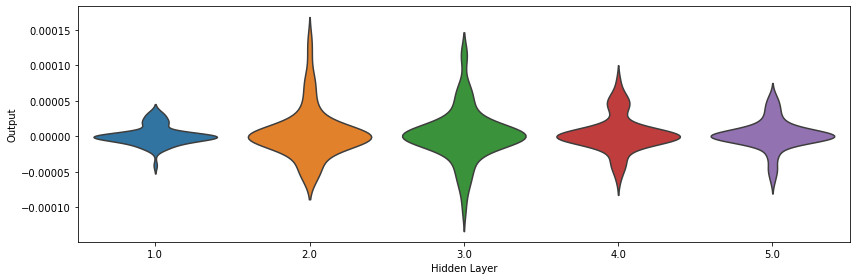

In [11]:
model = Net(F.relu)
model.init_normal(0.1)

plot_gradient_dist(model)

tensor(1.4349, grad_fn=<MseLossBackward0>)


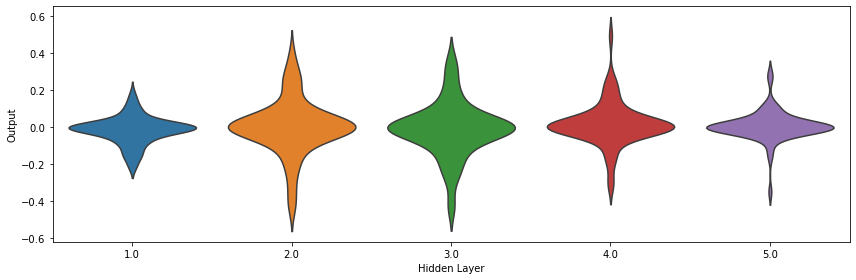

In [12]:
model = Net(F.relu)
model.init_normal(0.2)

plot_gradient_dist(model)

tensor(8.9179, grad_fn=<MseLossBackward0>)


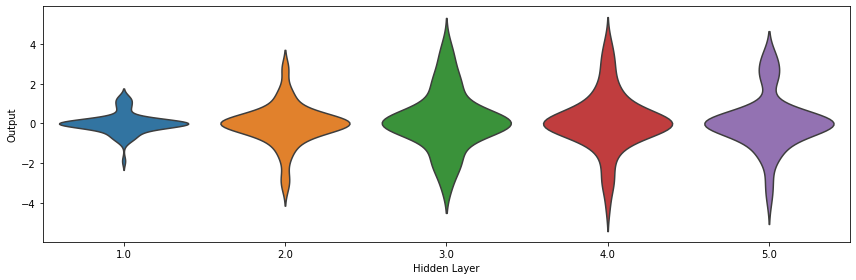

In [13]:
model = Net(F.relu)
model.init_normal(0.3)

plot_gradient_dist(model)

tensor(0.2212, grad_fn=<MseLossBackward0>)


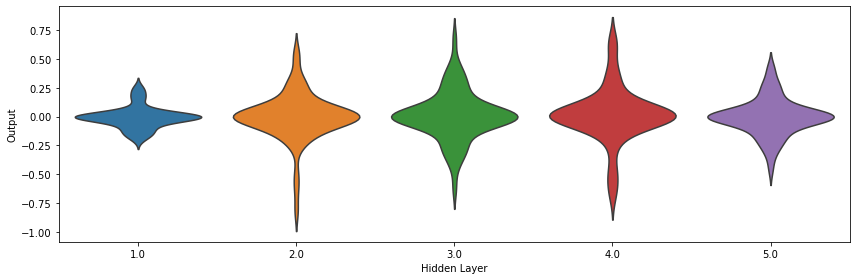

In [14]:
model = Net(F.relu)
model.init_kaiming_normal()

plot_gradient_dist(model)

## Activation: ReLU | Normal & Kaiming initialization | Plot: (epoch, Average gradient)

[EggHolder Function](https://www.indusmic.com/post/egg-holder-function) is very hard for function approximators (e.g., neural network) to optimize. 

$$ f(x) = -(x_2 + 47) \sin(\sqrt{  |   \frac{x_1}{2} + x_2  + 47  | })-x_1 \sin(  \sqrt{ | x_1 - (x_2  + 47) | }) $$

- Normal initialization
    - When $\sigma=0.1$, loss converge
    - When $\sigma=0.2$, loss often diverge to a large value or $\infty$
    - When $\sigma=0.3$, loss diverge to $\infty$ with high probabilitty
- Kaiming initialization
    - loss converge with high probabilitty

In [15]:
def f_eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))-x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))   

In [16]:
def plot_gradient_per_epoch(model, x_std=0.5, n_epoch=100): 
    gradient_per_epoch = []
    opt = SGD(model.parameters(), lr=1e-3)

    for i in range(n_epoch):
        opt.zero_grad() 
        x = torch.normal(0, x_std, [16])
        y_gt = f_eggholder(x)

        y_hat = model(x)
        loss = F.mse_loss(y_hat, y_gt)
        loss.backward()

        gradient_per_layer = []

        layers = [model.fc1, model.fc2, model.fc3, model.fc4, model.fc5]

        for i, layer in enumerate(layers):
            gradient_per_layer.append(layer.weight.grad.detach().numpy().mean())

        gradient_per_epoch.append(gradient_per_layer)

        opt.step()

    gradient_per_epoch = np.array(gradient_per_epoch)
    print('loss:', loss.detach().numpy())
    
    df = []

    for i in range(0,5):
        df.append(np.c_[np.repeat(i+1,n_epoch), range(n_epoch), gradient_per_epoch[:,i]])

    df = pd.DataFrame(np.concatenate(df), columns=['layer', 'epoch', 'gradient'])

    plt.figure(figsize=(12,5))
    sns.lineplot(data=df, x='epoch', y='gradient', hue='layer')

/tmp/ipykernel_12674/1434244773.py:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y_gt)


loss: 0.055349965


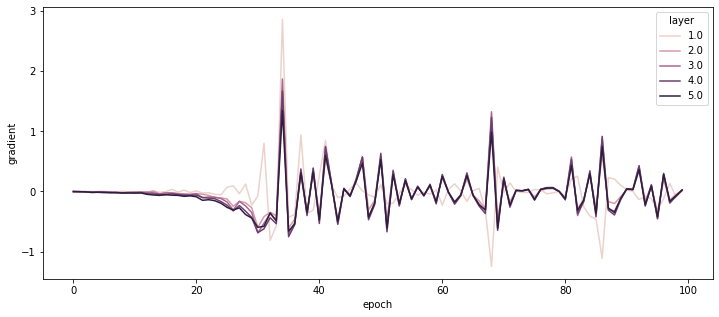

In [17]:
model = Net(F.relu)
model.init_normal(0.1)
plot_gradient_per_epoch(model)

/tmp/ipykernel_12674/1434244773.py:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y_gt)


loss: 514.1072


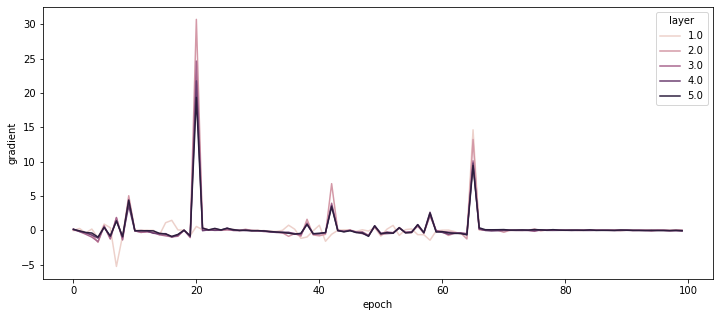

In [18]:
model = Net(F.relu)
model.init_normal(0.2)
plot_gradient_per_epoch(model)

/tmp/ipykernel_12674/1434244773.py:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y_gt)


loss: nan


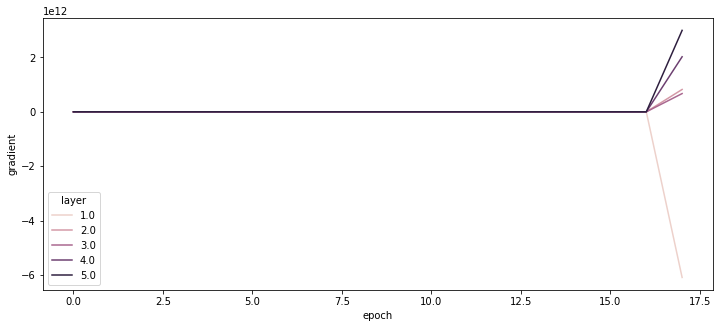

In [19]:
model = Net(F.relu)
model.init_normal(0.3)
plot_gradient_per_epoch(model)

/tmp/ipykernel_12674/1434244773.py:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y_gt)


loss: 1.0055466


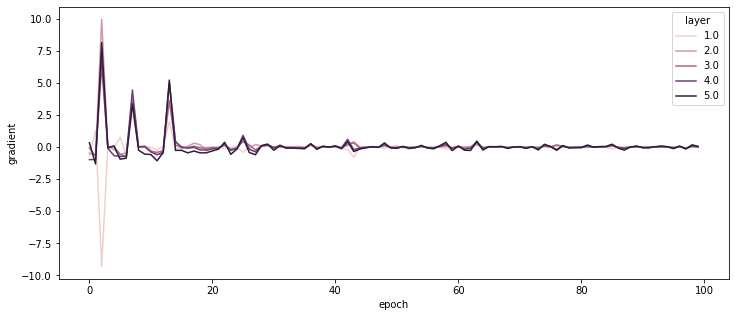

In [20]:
model = Net(F.relu)
model.init_kaiming_normal()
plot_gradient_per_epoch(model)

## Activation: tanh | Normal initialization | Post activation distribution
- Activation is slightly imbalanced for $\sigma = 0.1$
- Activation is ill-shaped for $\sigma = 0.2, 0.3$

/home/msi/app/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/tmp/ipykernel_12674/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
/tmp/ipykernel_12674/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
/tmp/ipykernel_12674/2258698805.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


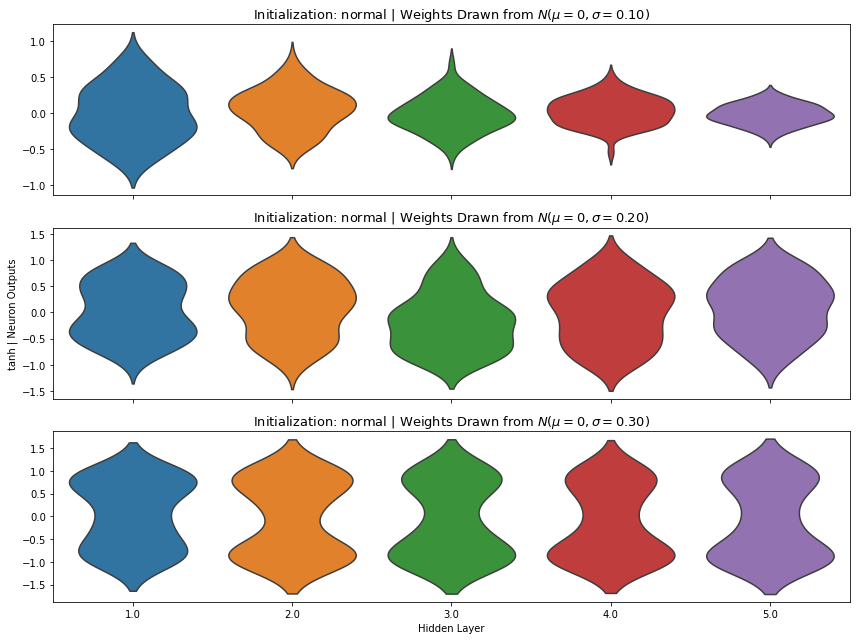

In [21]:
sigma_list = [0.10, 0.2, 0.3]
df_list = []

for sigma in sigma_list:    
    df_list.append(get_activation_df(F.tanh, sigma, x_std=1))
    
dff = pd.concat(df_list)
get_activation_plot(dff, 'tanh', 'normal', sigma_list)

## Activation: tanh | Xavier initialization | Post activation distribution
- No hyperparameter required
- Activation is more balanced

/home/msi/app/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


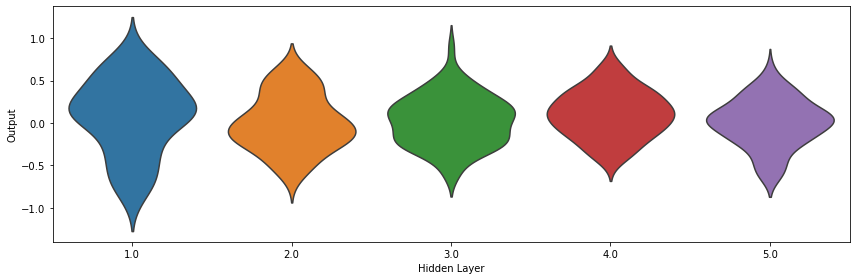

In [22]:
model = Net(F.tanh)
model.init_xavier_normal()

x = torch.normal(0, 1, [16])
y = model(x)

activation_per_layer = []

for i in range(1,6):
    activation_per_layer.append(np.c_[np.repeat(sigma, 64), np.repeat(i, 64), model.activation_value[i].detach().numpy()])

df = pd.DataFrame(np.concatenate(activation_per_layer, axis=0), columns=['Standard Deviation', 'Hidden Layer', 'Output'])

height = 5

fig = plt.figure(figsize=(12, 4))

sns.violinplot(x='Hidden Layer', y='Output', data=df, scale='count', inner=None)

plt.tight_layout()
plt.show()

## Activation: tanh | Xavier initialization | Plot: (epoch, Average gradient)
- Xavier initialization acturally performed worse than normal initialization with a a proper $\sigma$
- TBD: maybe due to the optimization problem? need to look into this

/home/msi/app/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/tmp/ipykernel_12674/1434244773.py:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y_gt)


loss: 0.36399633


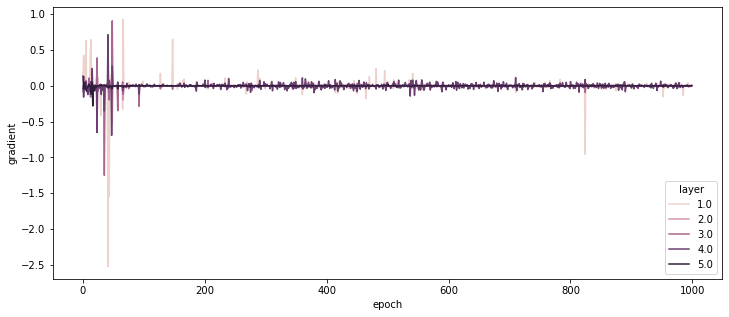

In [23]:
model = Net(F.tanh)
model.init_normal(0.2)
plot_gradient_per_epoch(model, x_std=1, n_epoch=1000)

/home/msi/app/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/tmp/ipykernel_12674/1434244773.py:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y_gt)


loss: 7.778499e-05


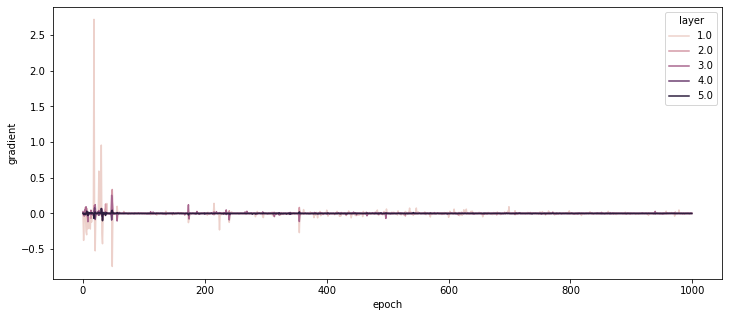

In [24]:
model = Net(F.tanh)
model.init_xavier_normal()
plot_gradient_per_epoch(model, x_std=1, n_epoch=1000)